## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


а) Данные рекомендации работают по единому принципу. Сначала расчитывается сходство между товарами(item-item) или пользователями(user-user), после чего дается рекомендация, как некоторое усреднение(очень условно) по заданному количеству соседей. <br>
б) Различие состоит в том, что в первом случае мы ищем сходство между товарами, а пользователи выступают в качестве признаков товара. В случае user-user - наоборот. Следовательно, один и тот же метод можно использовать в обоих случаях, просто транспонировав матрицу <br>
в) ALS - алгоритм, который подбирает значения эмбедингов (продуктов матричного разложения) методом градиентного спуска, в то время как item-item является детерменированным алгоритмом. 


2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


Количество просмотров/прослушиваний клипа или трека <br>
Количество поисковых запросов товара <br>
Длительность просмотра видео в % от его продолжительности (100% - посмотрел целиков, 0% не открывал, 5% начал смотреть и закрыл) <br>
Оценка товара на сайте <br>


3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


1) Нельзя работать с внешними признаками товаров и пользователей <br>
2) Учитывает линейные взаимодействия <br>

4. Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

а) Данный алгоритм придуман для ранжирования поисковой выдачи. Каждый документ оценивается по вхождению в него слов из поискового запроса. При этом каждое слово имеет свой "вес", исходя из того, насколько часто оно встречается в данных документах. Кроме того, формула учитывает как среднюю длину всех документов, так и каждого конкретного. Итогом данной формулы является значение, которое получается как сумма релевантностей каждого слова. <br>
б) Используя данное взвешивание, мы занижаем веса популярных товаров, и повышаем непопулярные. Таким образом, можем отранжировать веса товаров в обратном порядке и получить некий аналог popular_recommendation (при беглом гуглении вариантов не нашел)<br>

## Практическая часть


In [1]:
import implicit

In [2]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    #print(flags)
    
    
    precision = flags.sum() / len(recommended_list)
       
    return precision



def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data = pd.read_csv('retail_train.csv')
data.columns = [col.lower() for col in data.columns]

test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [6]:
result_train = data_train.groupby('user_id')['item_id'].unique().reset_index()
result_train.columns=['user_id', 'actual']
result_train.head(2)

,user_id,actual
0,1,"[825123, 831447, 840361, 845307, 852014, 85498..."
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55..."


In [7]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [8]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

C:\Users\Pavel\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [10]:
csr_mat = csr_matrix(user_item_matrix).T.tocsr()

In [11]:
%%time

model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=2)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


Wall time: 3.26 s


In [12]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

Wall time: 33.1 s


0.16297747306561983

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [10]:
user_item_matrix_tfidf = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [11]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=2)

model.fit(csr_matrix(user_item_matrix_tfidf).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()


Wall time: 35.6 s


0.16493633692458154

In [15]:
user_item_matrix_bm25 = bm25_weight(user_item_matrix.T).T 

In [16]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix_bm25).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()


Wall time: 29.9 s


0.18697355533790125

In [17]:
user_item_matrix_log = np.log(user_item_matrix + 1)

In [18]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix_log).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_log'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_log'], row['actual']), axis=1).mean()


Wall time: 27.8 s


0.14564152791380827

In [19]:
models = result.columns[2:]
score = []
for model_ in models:
    score.append(result.apply(lambda x: precision_at_k(x[model_], x['actual'], k=5), axis=1).mean())

In [20]:
evaluation = pd.DataFrame({'model': models, 'precision': score})
evaluation.sort_values('precision', ascending=False)

,model,precision
2,als_bm25,0.186974
1,als_tfidf,0.164153
0,als,0.162977
3,als_log,0.145642


### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.GridSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [27]:
result_test = data_test.groupby('user_id')['item_id'].unique().reset_index()
result_test.columns=['user_id', 'actual']

result_train = data_train.groupby('user_id')['item_id'].unique().reset_index()
result_train.columns=['user_id', 'actual']

In [40]:
from time import time

In [22]:
def create_model(data, factors, regularization, iterations):
    model = AlternatingLeastSquares(factors=factors, 
                                    regularization=regularization,
                                    iterations=iterations, 
                                    calculate_training_loss=True, 
                                    num_threads=2) # K - кол-во билжайших соседей

    model.fit(csr_matrix(data).T.tocsr(),  # На вход item-user matrix
              show_progress=True)
    
    return model

In [47]:
factors = [50, 100, 150]
regularizations = [0.001, 0.01, 0.1]
iterations = [15, 30, 50]



In [37]:
summary = []

In [48]:
%%time

for factor in factors:
    for regularization in regularizations:
        for iteration in iterations:
            
            start_time = time()
            model = create_model(user_item_matrix_bm25, factor, regularization, iteration)
            
            finish_time = time() - start_time
            
            result_test['test'] = result_test['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
            result_train['train'] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
            
            test_score = result_test.apply(lambda row: precision_at_k(row['test'], row['actual']), axis=1).mean()
            train_score = result_train.apply(lambda row: precision_at_k(row['train'], row['actual']), axis=1).mean()
            
            summary.append([factor, regularization, iteration, finish_time, test_score, train_score])
            
            


Wall time: 26min 57s


In [75]:
summary_df = pd.DataFrame(data=summary, 
                            columns=['factors', 'regularizations', 'iterations', 'time', 'test_score', 'train_score'])

In [76]:
summary_df.to_json('summary.json')

In [77]:
summary_df.sort_values('test_score', ascending=False).head(5)

,factors,regularizations,iterations,time,test_score,train_score
26,150,0.100,30,7.167831,0.199902,0.896679
25,150,0.100,15,3.649241,0.198825,0.894038
21,150,0.001,50,12.351967,0.198237,0.892197
20,150,0.001,30,7.447085,0.197943,0.897719
22,150,0.010,15,3.792856,0.197649,0.897799


In [88]:
summary_sorted = summary_df.sort_values('test_score')

Графики для роста кол-ва итераций


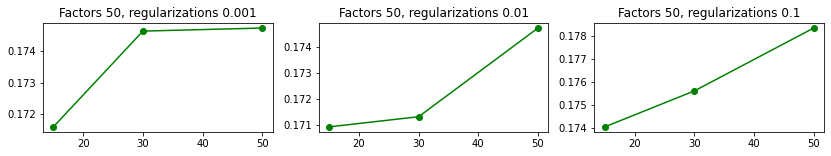

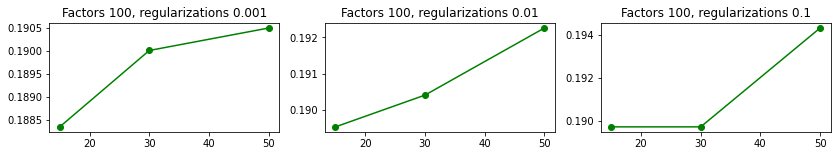

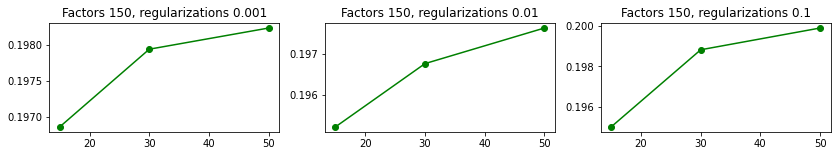

In [128]:
print('Графики для роста кол-ва итераций')
for factor in factors:
    f, ax = plt.subplots(1, 3, figsize=(14, 2))
    for i, regularization in enumerate(regularizations):
        ax[i].plot(iterations,
                 summary_sorted['test_score'].loc[(summary_sorted['factors'] == factor) \
                                          & (summary_sorted['regularizations'] == regularization)].values,
                 'go-')
        
        
        ax[i].title.set_text('Factors ' + str(factor) + ', regularizations ' + str(regularization))      

Графики для роста кол-ва факторов


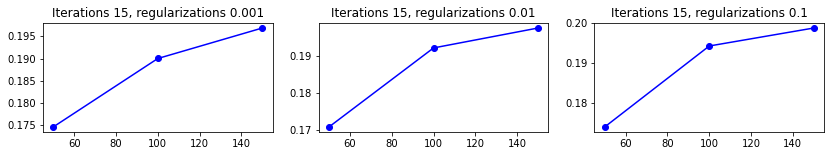

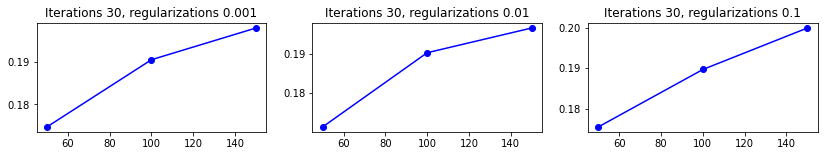

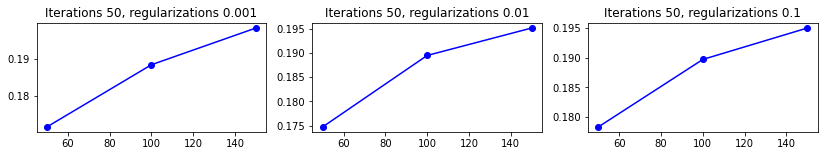

In [133]:
print('Графики для роста кол-ва факторов')
for iteration in iterations:
    f, ax = plt.subplots(1, 3, figsize=(14, 2))
    for i, regularization in enumerate(regularizations):
        ax[i].plot(factors,
                 summary_sorted['test_score'].loc[(summary_sorted['iterations'] == iteration) \
                                          & (summary_sorted['regularizations'] == regularization)].values,
                 'bo-')
        
        
        ax[i].title.set_text('Iterations ' + str(iteration) + ', regularizations ' + str(regularization))
       

Графики для роста кол-ва регуляризации


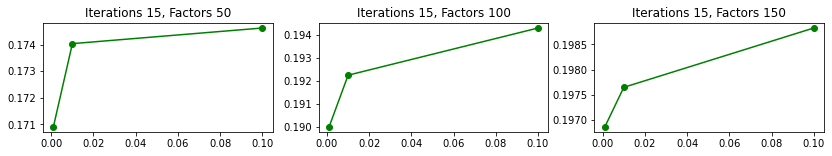

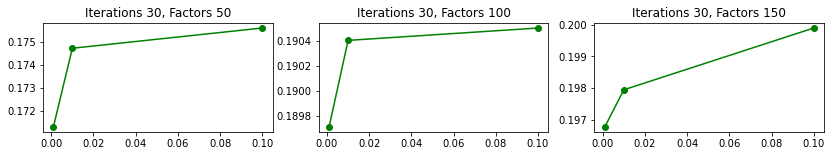

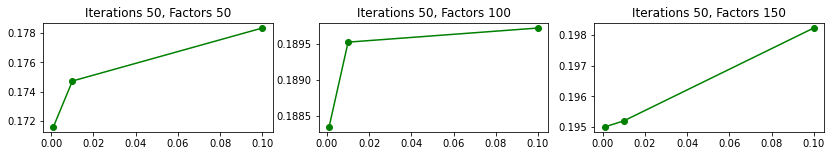

In [135]:
print('Графики для роста кол-ва регуляризации')
for iteration in iterations:
    f, ax = plt.subplots(1, 3, figsize=(14, 2))
    for i, factor in enumerate(factors):
        ax[i].plot(regularizations,
                 summary_sorted['test_score'].loc[(summary_sorted['iterations'] == iteration) \
                                          & (summary_sorted['factors'] == factor)].values,
                 'go-')
        
        
        ax[i].title.set_text('Iterations ' + str(iteration) + ', Factors ' + str(factor))  

In [154]:
summary_heapsort = summary_df.sort_values(by=['factors', 'regularizations', 'iterations'], kind='heapsort')

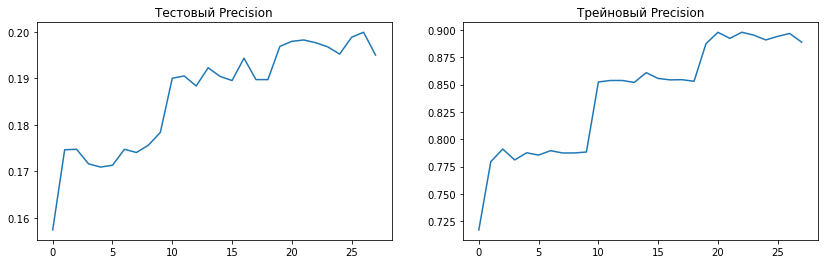

In [162]:
f, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(summary_heapsort['test_score'])
ax[0].title.set_text('Тестовый Precision')
ax[1].plot(summary_heapsort['train_score'])
ax[1].title.set_text('Трейновый Precision')

**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!

Самое существенное улучшение на качество модели оказал параметр factors (размер латентных факторов). При этом количество итераций всё еще больше всего влияет на время обучения<br>
Графики качества на обучающей и тестовой выборке достаточно похожи между собой по форме, но имеют огромное различие по абсолютной величине. <br>
Слишком высокие значения регуляризации негативно сказываются на качестве, оптимальной кажется стратегия повышения факторов и итераций, при невысокой регуляризации. <br>
В кривой обучения можно условно увидеть лестницу. На ней три ступеньки значительного роста качества - они ассоциированы с повышением количества факторов. При этом каждая последующая ступенька вырастает всё ниже и ниже. Врят ли успею проверить до дедлайна более длинный список параметров, чтобы узнать, когда их количество будет приводить к росту на трейне и падению на тесте (и будет ли вообще) <br>
Удивило, что при попытке нагуглить что-то по библиотеке implicit достаточно сложно, а официальная документация, скажем так, не слишком подробная. 

In [168]:
summary_df.sort_values(by=['time'], ascending=False).head(5)

,factors,regularizations,iterations,time,test_score,train_score
21,150,0.001,50,12.351967,0.198237,0.892197
24,150,0.010,50,12.020851,0.195201,0.890756
27,150,0.100,50,11.992927,0.195005,0.888756
15,100,0.010,50,9.980308,0.189520,0.855542
12,100,0.001,50,9.950388,0.188345,0.853701
